In [1]:
import torch as t
t.__version__

'0.4.1'

In [7]:
#初始化 但数值趋向正负无穷
x=t.Tensor(5,3)
y=t.Tensor(5,3)
x.mean(),y.mean()

(tensor(10563756733436288731342438400.), tensor(1.4013e-45))

In [12]:
#.size() return .Size类是tuple的子类 支持tuple的操作
x=t.randn(5,3)
y=t.randn([5,3])
x.size(),'\n',y.size()

(torch.Size([5, 3]), '\n', torch.Size([5, 3]))

In [25]:
# function name 带有‘_’ 是原地操作 但有返回值
z=t.add(x,y,out=None)
z=x.add(y)
print(x.mean())
z=x.add_(y)
print(x.mean())

tensor(-1.6966)
tensor(-1.9422)


In [27]:
#numpy2tensor
import numpy as np
a=np.random.randn(5,3)
b=t.from_numpy(a)
a,b

(array([[ 0.11168747,  0.2296542 , -1.33690496],
        [ 0.03367186, -1.33262169,  0.42655114],
        [-2.00321962,  0.09069531,  0.102239  ],
        [-0.23115481,  0.62720468, -1.39063236],
        [ 2.38323939, -0.61275082, -0.24948899]]),
 tensor([[ 0.1117,  0.2297, -1.3369],
         [ 0.0337, -1.3326,  0.4266],
         [-2.0032,  0.0907,  0.1022],
         [-0.2312,  0.6272, -1.3906],
         [ 2.3832, -0.6128, -0.2495]], dtype=torch.float64))

需要注意的是，`t.tensor()`总是会进行数据拷贝，新tensor和原来的数据不再共享内存。所以如果你想共享内存的话，建议使用`torch.from_numpy()`或者`tensor.detach()`来新建一个tensor, 二者共享内存。

In [29]:
old_tensor = b
new_tensor = t.tensor(old_tensor)
new_tensor[0][0]=1111
old_tensor,new_tensor

(tensor([[ 0.1117,  0.2297, -1.3369],
         [ 0.0337, -1.3326,  0.4266],
         [-2.0032,  0.0907,  0.1022],
         [-0.2312,  0.6272, -1.3906],
         [ 2.3832, -0.6128, -0.2495]], dtype=torch.float64),
 tensor([[ 1.1110e+03,  2.2965e-01, -1.3369e+00],
         [ 3.3672e-02, -1.3326e+00,  4.2655e-01],
         [-2.0032e+00,  9.0695e-02,  1.0224e-01],
         [-2.3115e-01,  6.2720e-01, -1.3906e+00],
         [ 2.3832e+00, -6.1275e-01, -2.4949e-01]], dtype=torch.float64))

In [30]:
new_tensor = old_tensor.detach()
new_tensor[0][0]=1111
old_tensor,new_tensor

(tensor([[ 1.1110e+03,  2.2965e-01, -1.3369e+00],
         [ 3.3672e-02, -1.3326e+00,  4.2655e-01],
         [-2.0032e+00,  9.0695e-02,  1.0224e-01],
         [-2.3115e-01,  6.2720e-01, -1.3906e+00],
         [ 2.3832e+00, -6.1275e-01, -2.4949e-01]], dtype=torch.float64),
 tensor([[ 1.1110e+03,  2.2965e-01, -1.3369e+00],
         [ 3.3672e-02, -1.3326e+00,  4.2655e-01],
         [-2.0032e+00,  9.0695e-02,  1.0224e-01],
         [-2.3115e-01,  6.2720e-01, -1.3906e+00],
         [ 2.3832e+00, -6.1275e-01, -2.4949e-01]], dtype=torch.float64))

## autograd 自动微分

In [32]:
# 为tensor设置requires_grad 标识
x=t.ones(2,2,requires_grad=True)
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [39]:
y=x.sum()
y

tensor(4., grad_fn=<SumBackward0>)

In [40]:
y.grad_fn

In [43]:
y.backward()

In [45]:
# 每次反向传播的结果都是累加的 需要手动将梯度清零
x.grad

tensor([[2., 2.],
        [2., 2.]])

In [47]:
x.grad.data.zero_()
y.backward()
x.grad

tensor([[1., 1.],
        [1., 1.]])

#### 定义网络

定义网络时，需要继承`nn.Module`，并实现它的forward方法，把网络中具有可学习参数的层放在构造函数`__init__`中。如果某一层(如ReLU)不具有可学习的参数，则既可以放在构造函数中，也可以不放，但建议不放在其中，而在forward中使用`nn.functional`代替。

In [49]:
import torch.nn as nn
import torch.nn.functional as F

In [51]:
#forward 函数定义后backward会根据autograd自动实现
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [61]:
for name,para in net.named_parameters():
    print((name,':',para.size()))

('conv1.weight', ':', torch.Size([6, 1, 5, 5]))
('conv1.bias', ':', torch.Size([6]))
('conv2.weight', ':', torch.Size([16, 6, 5, 5]))
('conv2.bias', ':', torch.Size([16]))
('fc1.weight', ':', torch.Size([120, 400]))
('fc1.bias', ':', torch.Size([120]))
('fc2.weight', ':', torch.Size([84, 120]))
('fc2.bias', ':', torch.Size([84]))
('fc3.weight', ':', torch.Size([10, 84]))
('fc3.bias', ':', torch.Size([10]))


In [62]:
input = t.randn(1,1,32,32)
out = net(input)
out.size()

torch.Size([1, 10])

In [63]:
net.zero_grad()
out.backward(t.ones(1,10))

In [65]:
output = net(input)
target = t.arange(0,10).view(1,10).float()
criterion = nn.MSELoss()
loss = criterion(output,target)
loss

tensor(28.9860, grad_fn=<MseLossBackward>)

In [86]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(),lr=0.01)
optimizer.zero_grad()
output = net(input)
loss = criterion(output,target)
loss.backward()
optimizer.step()

In [87]:
loss

tensor(71.2085, grad_fn=<MseLossBackward>)

## CIFAR-10

In [88]:
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage()

In [89]:
transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(
                            (0.5,0.5,0.5),
                            (0.5,0.5,0.5)
                        )
])
trainset = tv.datasets.CIFAR10(
                        root = '../data/',
                        train = True,
                        download = True,
                        transform = transform
)
trainloader = t.utils.data.DataLoader(
                            trainset,
                            batch_size = 4,
                            shuffle = True,
                            num_workers = 2
)
# 测试集
testset = tv.datasets.CIFAR10(
                    '../data/',
                    train=False, 
                    download=True, 
                    transform=transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=4, 
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ship


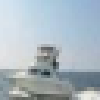

In [96]:
(data,label) = trainset[100]
print(classes[label])
show(data/2+0.5).resize((100,100))

In [99]:
data.size(),label

(torch.Size([3, 32, 32]), 8)

In [93]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [104]:
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
t.set_num_threads(100)
for epoch in range(2):
    Loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        
        optimizer.step()
        
        Loss += loss.item()
        if i%2000 ==0:
            print('[%d,%5d] loss : %3f' %(epoch,i,Loss/2000))
            Loss=0.0
print('finish')

[0,    0] loss : 0.000521
[0, 2000] loss : 1.121226
[0, 4000] loss : 1.087799
[0, 6000] loss : 1.107974
[0, 8000] loss : 1.105258
[0,10000] loss : 1.075931
[0,12000] loss : 1.081823
[1,    0] loss : 0.000121
[1, 2000] loss : 1.008848
[1, 4000] loss : 1.021513
[1, 6000] loss : 1.035864
[1, 8000] loss : 1.020415
[1,10000] loss : 1.012316
[1,12000] loss : 1.057487
finish


label: cat ship ship plane


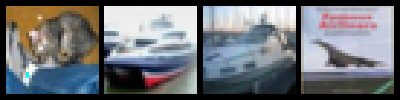

In [110]:
dataiter = iter(testloader)
images,labels = dataiter.next()
print('label:',' '.join(classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images/2-0.5)).resize((400,100))

In [115]:
outputs = net(images)
_,predicted = t.max(outputs,1)

print(' '.join(classes[predicted[j]] for j in range(4)))

dog ship ship ship


In [116]:
correct,total = 0,0

with t.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _,predicted = t.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum()
print('all: ',total,' correct: ',correct)

all:  10000  correct:  tensor(6183)
